In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
import tqdm

warnings.filterwarnings("ignore")

with open("../../datasets/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

# Разбитие на анектоды
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]
cut_text = cut_data(text)


# Задание 4. RNN
## Задача 1. 3 балла
Обучите RNN/LSTM на данных из классной работы, используя другой токенайзер. Опишите его и свой выбор. Покажите разницу в генерации моделей, обученных с разными токенайзерами.
## {*} Задача 1.1 2 балла
Напишите свой токенайзер вручную, с использованием только библиотек numpy, torch, sklearn, stats, опционально других пакетов, не предоставляющих готовые инструменты токенизации и т.п., за исключением предобработки текста (лемматизация, стеминг и т.д.) . 


In [2]:
class Custom_Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.char2int)
        self.char2int[symbol] = sym_num
        self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char) # your code
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.int2char[toc] for toc in idx] # list[int] -> list[str]

    def encode(self, chars, eos=True):
        if eos:
            chars = ['<bos>'] + list(chars) + ['<eos>']
        else:
            chars = ['<bos>'] + list(chars)
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars) # make string from list


In [3]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 256):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
    
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, item):
        #  в идеале запонлять паддингами лучше в другом месте
        encoded = self.tokenizer.encode(self.cut_text[item])[:self.max_len]
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.long)
        padded[:len(encoded)] = torch.tensor(encoded)
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        return padded, len(encoded)

# Optionally add new methods to your dataset class

In [4]:
class CharRNN(nn.Module):
    
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        # create mappings
        self.tokenizer = tokenizer

        ## define the LSTM, dropout and fully connected layers
        self.encoder = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=self.drop_prob
        )
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.decoder = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.tokenizer.vocab_size,
        )

    # Forward - это проход вперёд по слою
    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # one-hot encode your sequence
        packed_embeds = self.encoder(x) # pack your sequence. This helps with the efficiency. Use torch function pack_padded_sequence
        outputs, hidden = self.rnn(packed_embeds) # run you model
        
        # TODO: Понять нафига
        #  out, lengths = # pad sequence back
        
        # Pass through a dropout layer and fully connected layer
        out = self.dropout(outputs)
        ## Get the output for classification.
        out = self.decoder(out)

        return out, hidden

    
    # инференс - режим не обучения (По сути штатная работа)
    def inference(self, prefix='<bos> ', device="cpu"):
        tokens = torch.tensor([self.tokenizer.encode(prefix, eos=False)], device=device) # encode prefix
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        # Generate sequence iteratively
        for _ in range(self.max_len - len(tokens[0])):
            # YOUR CODE: generate sequence one by one
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token.item() == self.tokenizer.encode_symbol("<eos>"):
                break
        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze().tolist())


In [5]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs, lengths = train_batch
    inputs = inputs.to(device)
    lengths = lengths.to(device)

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    outputs, _ = model(inputs[:, :-1], lengths)

    # Переформатирование выходов и целевых меток для расчета функции потерь
    outputs = outputs.view(-1, vocab_size)
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(outputs, targets)

    # Обратный проход
    loss.backward()

    # Шаг оптимизации
    optimizer.step()
    return loss.item()

In [6]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [7]:
batch_size = 100
seq_length = 512
n_hidden = 64 #256
n_layers = 4 #4
drop_prob = 0.1
lr = 0.001
device = 'cpu'

In [8]:
tokenizer = Custom_Tokenizer(text)

In [9]:
model = CharRNN(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob)
hidden = None
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)

In [10]:
dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

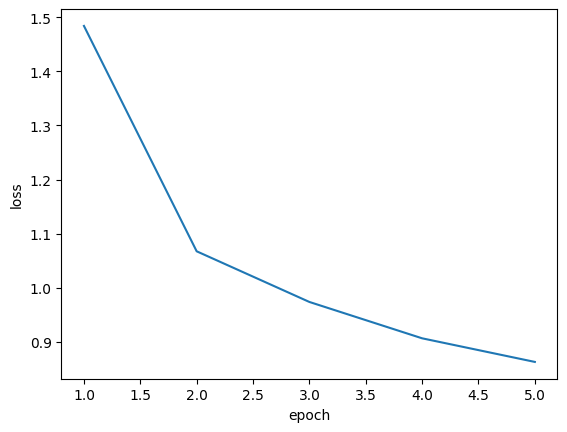

In [11]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    with tqdm.tqdm(total=len(dataloader)) as prbar:
        for i, batch in enumerate(dataloader):
            loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
            epoch_loss += loss
        
            if i % 100 == 0:
                #print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
                metrics_str = f"Loss: {round(loss, 4)} "
                #for k, v in metrics_dict.items():
                #    metrics_str += f"{k}: {round(float(v), 4)} "
                prbar.set_description(metrics_str)
                prbar.update(100)
    
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    #torch.save(model.state_dict(), "rnn.pt")
    torch.save(model, "rnn.pt")

In [12]:
#model.load_state_dict(torch.load("rnn.pt", weights_only=True))
model = torch.load("rnn.pt", weights_only=False)

model.eval()

CharRNN(
  (encoder): Embedding(217, 64)
  (rnn): LSTM(64, 64, num_layers=4, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (decoder): Linear(in_features=64, out_features=217, bias=True)
)

In [13]:
[model.inference("Пилите, Шура, пилите. Они ", device=device) for _ in range(10)]

['<bos>Пилите, Шура, пилите. Они ответиться раковали ной!<eos>',
 '<bos>Пилите, Шура, пилите. Они даже кега кот в сде клак, что.<eos>',
 '<bos>Пилите, Шура, пилите. Они это это туамова так в этох двах, задав момный умерении себе до буситаной...<eos>',
 '<bos>Пилите, Шура, пилите. Они Мисно проскерыю.<eos>',
 '<bos>Пилите, Шура, пилите. Они ей хатьице бвипей тут.<eos>',
 '<bos>Пилите, Шура, пилите. Они фитум попросил, чко выэто стоят предзабчай любитки жизнь...<eos>',
 '<bos>Пилите, Шура, пилите. Они женой посадилении, чтоба озежую бритирент кой.- Додать, что аза вобликаюсь, а были!<eos>',
 '<bos>Пилите, Шура, пилите. Они по извегат семья "Видетнлюсье быть нов сторого когда сава влучают на порюки отметать...<eos>',
 '<bos>Пилите, Шура, пилите. Они что мочто развели спрашиу другому захуйчась песму налучкарист этом и фотогрыгней первы?<eos>',
 '<bos>Пилите, Шура, пилите. Они просыр морожения заечно:- Осазнет, - происял и трабыю светов, видиты, чтобы проходит - я есть?- Памите? - Давай?- А

## Задача 2. 3 балла
Реализуйте с помощью только torch/numpy слой RNN, обучите его на данных из классной работы и, опционально, своих данных. Покажите, что модель обучается
## {*} Задача 2.1 +1 балл
За реализацию слоев GRU/LSTM/bidirectional RNN, многослойной модели по +1 баллу к базовым (даже если ванильная RNN не реализована)

## Задача 3. 1/2/3/4 балла
**TBD**: 
Попробуйте обучить рекуррентную сеть задаче классификации. Вы можете воспользоваться сторонними библиотеками для вашей работы, 
но модель и основной код должны быть написаны на pytorch. 

##  {*} Задача 4. 5/6/7/8 баллов
[ссылка](https://www.kaggle.com/t/b2ef08dc3ddf44f981e2ad186c6c508d)

Попробуйте обучить сверточную нейронную сеть задаче детекции людей на изображениях разного стиля. Вы можете воспользоваться сторонними библиотеками для вашей работы. Однако, за неисопользование полностью готовых скриптов обучения (как в классной работе) вы получите дополнительные2 балла